In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
from descartes import PolygonPatch
import rasterio
from shapely.geometry import mapping
from skimage.measure import find_contours
import fiona
from fiona.crs import from_epsg
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [2]:
def to_shape(data,path,transform,crs):
    # 폴리곤으로 변환
    polygons = []
    for value in np.unique(data):
        if value == 0:
            continue
        contours = find_contours(data == value, 0.5)
        for contour in contours:
            # 픽셀 좌표를 지리 좌표로 변환
            contour = np.array([transform * (c[1], c[0]) for c in contour])
            polygon = Polygon(contour)
            polygons.append(polygon)

    # 겹치는 부분을 제거하고 병합
    merged_polygons = unary_union(polygons)

    # 병합된 폴리곤에서 중복된 부분을 제외하고 Shapefile에 저장
    schema = {
        'geometry': 'Polygon',
        
        'properties': {'value': 'int'}
    }

    with fiona.open(path, 'w', driver='ESRI Shapefile', schema=schema, crs=crs) as dst:
        if isinstance(merged_polygons, Polygon):
            dst.write({
                'geometry': mapping(merged_polygons),
                'properties': {'value': 1}
            })
        elif isinstance(merged_polygons, MultiPolygon):
            for poly in merged_polygons.geoms:
                dst.write({
                    'geometry': mapping(poly),
                    'properties': {'value': 1}
                })

    print(f'Shapefile saved as {path}')

In [3]:
def make_map(pred, gt, height, width, name):
    """예측 결과와 실제 값을 비교하여 시각화 맵을 생성하는 함수
    
    Args:
        pred: 예측값 배열
        gt: 실제값(ground truth) 배열 
        height: 이미지 높이
        width: 이미지 너비
        name: 저장할 파일명
    """
    # 입력 배열 reshape
    pred = np.array(pred).reshape(height, width)
    gt = np.array(gt).reshape(height, width)

    # 결과 배열 생성 
    result = np.zeros_like(pred)
    
    # 예측값과 실제값 비교하여 결과 매핑
    match_mask = (gt == pred)
    result[match_mask] = gt[match_mask]
    
    mismatch_mask = ~match_mask
    result[mismatch_mask & (gt == 1)] = 2  # 미탐지
    result[mismatch_mask & (gt == 0)] = 3  # 오탐지

    # 시각화 설정
    colors = ['white', 'green', 'red', 'blue']
    labels = ['배경', '정탐지', '미탐지', '오탐지']
    cmap = ListedColormap(colors)
    
    # 그래프 생성
    plt.figure(figsize=(16, 9))
    legend_elements = [Patch(facecolor=color, edgecolor=color, label=label) 
                      for color, label in zip(colors[1:], labels[1:])]
    
    plt.axis('off')
    plt.imshow(result, cmap=cmap, interpolation='nearest')
    plt.legend(handles=legend_elements)
    
    # 결과 저장
    plt.savefig(name, bbox_inches="tight")
    plt.close()

## 결과 시각화

In [7]:
for k in range(7,11,2):
    df = pd.read_csv(f"../result/result_gs_2307_sub_m6_{k}_20250401_xgb.csv",engine='python')
    tmp = np.zeros(2799*2563)
    # tmp = np.zeros(1843*2715)
    gt = np.zeros(2799*2563)
    # gt = np.zeros(1843*2715)
    df2 =pd.read_csv('../data/gs_2307_remove_index.csv')
    df['Prediction (target)'] = np.where(df['P (target=1)'] >= 0.5, 1, 0)
    for i in range(len(df2)):
        idx=df2['location'][i]-1
        pred=df['Prediction (target)'][i]
        tmp[idx]=pred
        tar=df['target'][i]
        gt[idx]=tar
        
    make_map(tmp,gt,2799,2563,f"gs_sub_m6_{k}_plot_2307_add_legend.png")

## DBSCAN 결과 시각화

In [ ]:
for mm in [6,7,8]:
    tif_file = f'../영상 데이터/2023/hyper/03_20230{mm}03_Gongsan_Hyper_Subset'
    height=2799
    width=2563
    with rasterio.open(tif_file) as src:
        transform = src.transform
        crs = src.crs
    con=[]   
    con1=[]   
    con2=[]     
    for k in range(1,7,1):
        for l in [20]:
            df = pd.read_csv(f"../result/remove_gs_230{mm}_sub_m{k}_{l}%.csv",engine='python')
            tmp = np.zeros(height*width)
            gt = np.zeros(height*width)
            df2 =pd.read_csv(f'../data/gs_230{mm}_remove_index.csv')
            thres=0.8
            precision, recall, thresholds = precision_recall_curve(df['target'], df['P (target=1)'])
            target_recall = 0.75
            idx = np.argmin(np.abs(recall - target_recall))
            if idx < len(thresholds):
                thres=thresholds[idx]
                print(thres)
            else:
                thres= 0.8
            df['Prediction (target)'] = np.where(df['P (target=1)'] >= thres, 1, 0)
            for i in range(len(df2)):
                idx=df2['location'][i]-1
                pred=df['Prediction (target)'][i]
                tmp[idx]=pred
                tar=df['target'][i]
                gt[idx]=tar
            predictions = (tmp >= thres).astype(int)
            true_labels = gt
            # make_map(predictions,true_labels,height,width,f'./img/gs_sub_m{k}_230{mm}_new.png')

            array_2d = np.array(predictions).reshape(height,width)
            
            cm = confusion_matrix(true_labels, predictions)
            # TN, FP, FN, TP 추출
            TN, FP, FN, TP = cm.ravel()
            
            # 결과를 리스트에 추가
            con.append({
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'TP': TP,
                'ratio': l,
                'model' : f'm{k}'
            })
            
            
            # Step 2: Convert 2D array to list of coordinates
            coordinates = np.argwhere(array_2d == 1)
            # Step 5: DBSCAN 적용
            eps = 3  # K-거리 그래프를 통해 얻은 eps 값
            min_samples = 20  # 데이터의 특성에 맞게 설정

            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(coordinates)

            # Step 6: 고립점 찾기
            noise_points = coordinates[clusters == -1]

            # 고립점에 해당하는 곳을 0으로 설정
            for point in noise_points:
                array_2d[point[0], point[1]] = 0

            # 고립점을 제외한 좌표
            non_noise_coordinates = coordinates[clusters != -1]
            non_noise_clusters = clusters[clusters != -1]
            
            pred_labels = array_2d.reshape(-1)
            # make_map(pred_labels,true_labels,height,width,f'./img/gs_sub_m{k}_dbscan_230{mm}_new.png')
            # to_shape(array_2d,f'./ploy/dbscan_gs_m{k}_230{mm}_new.shp',transform,crs)
            cm = confusion_matrix(true_labels, pred_labels)
            # TN, FP, FN, TP 추출
            TN, FP, FN, TP = cm.ravel()
            
            # 결과를 리스트에 추가
            con1.append({
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'TP': TP,
                'ratio': l,
                'model' : f'm{k}'
            })
    #-------------------------------------------

            unique_clusters = np.unique(non_noise_clusters)
            area_threshold = 100  # 면적 임계값, 필요한 값으로 조정
            convex_hulls = []
            valid_points = []
            valid_coords = []
            for cluster in unique_clusters:
                cluster_points = non_noise_coordinates[non_noise_clusters == cluster]
                if len(cluster_points) >= 3:  # ConvexHull을 계산하려면 최소 3개의 점이 필요
                    try:
                        # 작은 무작위 변동을 추가하여 수치 안정성을 향상
                        perturbation = np.random.normal(scale=1e-6, size=cluster_points.shape)
                        hull = ConvexHull(cluster_points + perturbation)
                        hull_points = np.append(hull.vertices, hull.vertices[0])  # 닫힌 다각형을 만들기 위해 첫 번째 점을 추가
                    
                        # Convex Hull의 면적 계산
                        hull_area = hull.volume  # 2D에서는 volume이 면적을 나타냄
                        if hull_area > area_threshold:
                            # plt.plot(cluster_points[hull_points, 1], cluster_points[hull_points, 0], 'r--', lw=1)
                            valid_coords.append(hull_points)
                            valid_points.append(cluster_points)
                            convex_hulls.append(cluster_points[hull_points])
                        else:
                            for point in cluster_points:
                                array_2d[point[0], point[1]] = 0  # 작은 클러스터의 점을 제거
                    except Exception as e:
                        print(f"Cluster {cluster}: {e}")

            # # 유효한 점들을 다시 결합
            if valid_points:
                valid_points = np.vstack(valid_points)

    # # -------------------------------------------
    #         # Step 8: 컨퓨전 메트릭스 그리기
    #         # 실제 라벨과 예측 라벨을 가져오기
            pred_labels = array_2d.reshape(-1)
            cm = confusion_matrix(true_labels, pred_labels)
            # TN, FP, FN, TP 추출
            TN, FP, FN, TP = cm.ravel()
            
            # 결과를 리스트에 추가
            con2.append({
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'TP': TP,
                'ratio': l,
                'model' : f'm{k}'
            })
            to_shape(array_2d,f'./ploy/final_gs_m{k}_230{mm}_new.shp',transform,crs)
            make_map(pred_labels,true_labels,height,width,f'./img/gs_sub_m{k}_remove_small_area_230{mm}_new.png')
    df = pd.DataFrame(con)
    df1 = pd.DataFrame(con1)
    df3= pd.DataFrame(con2)

    # 데이터프레임 출력 (또는 CSV 파일로 저장)
    df.to_csv(f'confusion_matrix_results_gs_230{mm}_{eps}.csv', index=False)
    df1.to_csv(f'confusion_matrix_results_gs_dbscan_230{mm}_{eps}.csv', index=False)
    df3.to_csv(f'confusion_matrix_results_gs_remove_small_area_230{mm}_{eps}.csv', index=False)

## Convex hul

## -------------------

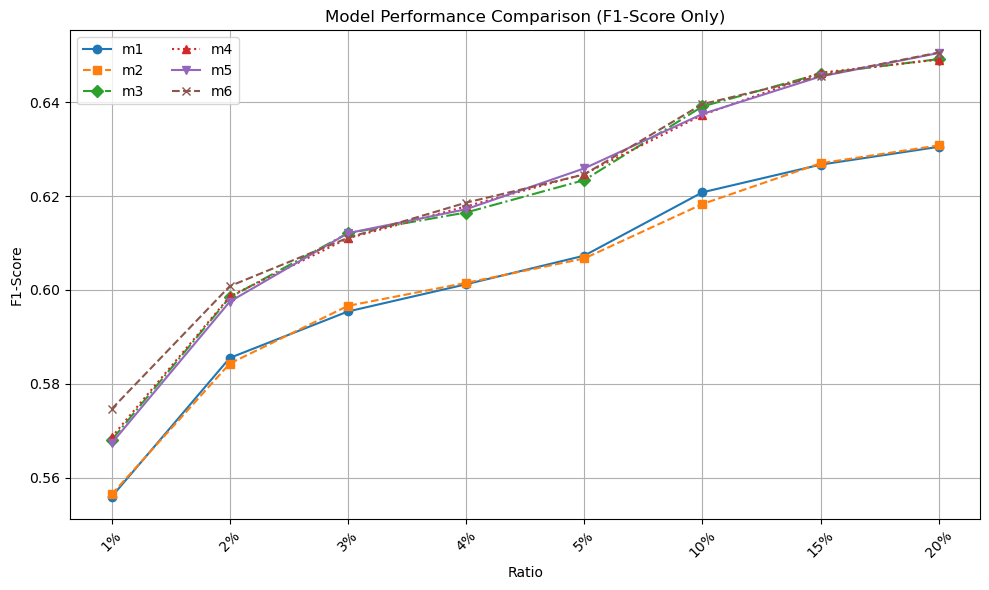

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from the image
data = {
    "Ratio": ["1%", "1%", "1%", "1%", "1%", "1%", "2%", "2%", "2%", "2%", "2%", "2%", "3%", "3%", "3%", "3%", "3%", "3%", 
              "4%", "4%", "4%", "4%", "4%", "4%", "5%", "5%", "5%", "5%", "5%", "5%", "10%", "10%", "10%", "10%", "10%", "10%", 
              "15%", "15%", "15%", "15%", "15%", "15%", "20%", "20%", "20%", "20%", "20%", "20%"],
    "Model": ["m1", "m2", "m3", "m4", "m5", "m6", "m1", "m2", "m3", "m4", "m5", "m6", "m1", "m2", "m3", "m4", "m5", "m6",
              "m1", "m2", "m3", "m4", "m5", "m6", "m1", "m2", "m3", "m4", "m5", "m6", "m1", "m2", "m3", "m4", "m5", "m6",
              "m1", "m2", "m3", "m4", "m5", "m6", "m1", "m2", "m3", "m4", "m5", "m6"],
    "F1 Score": [0.5559,0.5564,0.5680,0.5686,0.5673,0.5746,0.5855,0.5843,0.5984,0.5986,0.5975,0.6008,0.5954,0.5966,0.6121,0.6110,0.6121,0.6111,0.6012,0.6015,0.6165,0.6178,0.6172,0.6186,0.6073,0.6067,0.6234,0.6247,0.6259,0.6246,0.6208,0.6183,0.6391,0.6373,0.6375,0.6396,0.6267,0.6270,0.6461,0.6463,0.6455,0.6456,0.6305,0.6308,0.6492,0.6491,0.6505,0.6506
]
}

# Create DataFrame
df = pd.DataFrame(data)

# Define markers and line styles for each model
markers = ['o', 's', 'D', '^', 'v', 'x']
line_styles = ['-', '--', '-.', ':', '-', '--']

# Plotting the graph for only F1 scores
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting F1 scores for each model with different markers and line styles
for idx, model in enumerate(df['Model'].unique()):
    subset = df[df['Model'] == model]
    ax.plot(subset['Ratio'], subset['F1 Score'], marker=markers[idx], linestyle=line_styles[idx], label=f'{model}')

# Labels and Title
ax.set_xlabel('Ratio')
ax.set_ylabel('F1-Score')
ax.set_title('Model Performance Comparison (F1-Score Only)')
ax.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(loc='best', ncol=2)
plt.show()


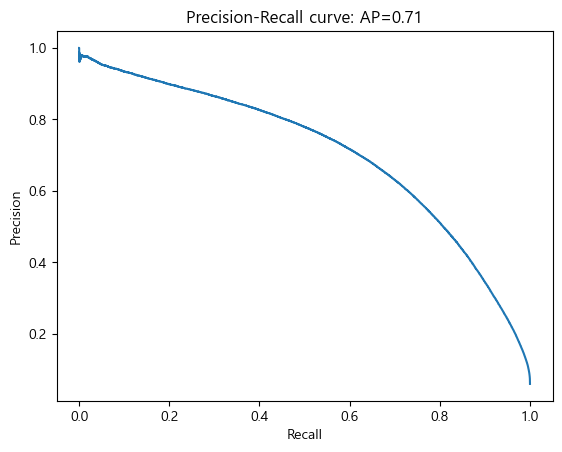

Recall이 0.75일 때의 Threshold 값: 0.80


In [4]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
df = pd.read_csv(f"../result/remove_gs_2307_sub_m6_20%.csv",engine='python')
# Precision-Recall 커브 계산
precision, recall, thresholds = precision_recall_curve(df['target'], df['P (target=1)'])

# Average Precision (AP) 점수 계산
average_precision = average_precision_score(df['target'], df['P (target=1)'])

# PR 커브 시각화
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve: AP={average_precision:0.2f}')
plt.show()

# Recall이 0.75에 가장 가까운 인덱스 찾기
target_recall = 0.75
idx = np.argmin(np.abs(recall - target_recall))

# 해당 인덱스의 threshold 값 출력 (thresholds는 recall보다 1개 적음)
if idx < len(thresholds):
    print(f'Recall이 {target_recall}일 때의 Threshold 값: {thresholds[idx]:.2f}')
else:
    print("해당 recall에 대응하는 threshold 값을 찾을 수 없습니다.")